In [ ]:
import os
import cv2
import numpy as np
import torch
import dlib
from imutils import face_utils
from basicsr.archs.rrdbnet_arch import RRDBNet
from basicsr.utils.download_util import load_file_from_url
from torchvision import transforms  
import torch.nn as nn
from torch.utils.data import Dataset
from albumentations.pytorch import ToTensorV2
import albumentations as A
import torch.nn.functional as F
import math
import time
from imutils import face_utils
from scipy.spatial import distance as dist
import matplotlib.pyplot as plt
import mediapipe
from BaseModels.resnetModels import BB_model
from BaseModels.efficientnetModels import BB_model
import pandas as pd
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from scipy.spatial import distance
sys.path.append("../../")
from utils import *



    


In [2]:
# # Load Model 256
model_U = torch.load(
    "/home/nipun/Documents/Uni_Malta/LuminEye/LuminEye-Experiments/U2net/U2NET_MULTICLASS_IMG_256_DIC_batch_8/Miche_model_2023_04_11_22:14:26_val_iou0.900.pt", map_location=device)


model_U.eval()

RESIZE_AMT = 256

In [3]:
val_csv_path = "/home/nipun/Documents/Uni_Malta/Datasets/CenterRegression/H2HEAD/AllCoords/AllCoordsTestH2head.csv"

val_df = pd.read_csv(val_csv_path)



print(val_df.head())

   Unnamed: 0.1  Unnamed: 0  \
0             1           1   
1             9           9   
2            12          12   
3            14          14   
4            21          21   

                                           ImageName  \
0  I2Head/user_01/17_points_Trans_Bwd/position_in...   
1  I2Head/user_01/17_points_Trans_Bwd/position_in...   
2  I2Head/user_01/17_points_Trans_Bwd/position_in...   
3  I2Head/user_01/17_points_Trans_Bwd/position_in...   
4  I2Head/user_01/17_points_Trans_Fwd/position_in...   

                                         Coordinates  
0  [621.3945467545384, 299.9778803412308, 641.135...  
1  [622.7140720599232, 303.92687809399996, 642.13...  
2  [623.5165281744231, 304.41340942899996, 634.94...  
3  [625.5169121350768, 305.6254918444615, 641.500...  
4  [602.1994594876537, 287.2514239163846, 616.393...  


In [4]:
def selectImgDir(datasetType:str):
    
    
    
    
    
    if datasetType == "MP2GAZE":
        return "/home/nipun/Documents/Uni_Malta/Datasets/"
        
        
        
    elif datasetType =="i2head":
        return "/home/nipun/Documents/Uni_Malta/Datasets/"
        
    elif datasetType == "GI4E":
        
        return "/home/nipun/Documents/Uni_Malta/Datasets/gi4e_database/images/"
        
        
        
        
    
    
    

In [5]:
detector = None
predictor = None
GAN_MODEL = None
IRIS_MODEL = None
EYE_AR_THRESH = 0.2

mp_face_mesh = mediapipe.solutions.face_mesh

face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True)


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [6]:
def imgTransform(image):
    """ Transform numpy images to Torch tensors

    Args:
        image (_numpy_): _cropped_eye_region_
        resize_amt (_int_): _Input Resize for the image_

    Returns:
        _torch.float32_: _Transformed image tensor_
    """

    transform = A.Compose([
        A.Resize(RESIZE_AMT, RESIZE_AMT),
        A.augmentations.transforms.Normalize(
            mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
        ToTensorV2()
    ])

    return transform(image=image)["image"]

In [7]:
def predict_image_masku2net(model, image):

    image = imgTransform(image[:, :, ::-1])

    image = image.to(device)

    with torch.no_grad():

        softmax = nn.Softmax(dim=1)
        image = image.unsqueeze(0)

        model_output, _, _, _, _, _, _ = model(image)

        output = softmax(model_output)

        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked

In [9]:
def decode_segmap(temp, n_classes=3):

    colors = [[0,   0,   0], [0, 255, 0], [0, 0, 255]]
    label_colours = dict(zip(range(n_classes), colors))
    # convert gray scale to color
    temp = temp.numpy()
    r = temp.copy()
    g = temp.copy()
    b = temp.copy()
    for l in range(n_classes):
        r[temp == l] = label_colours[l][0]
        g[temp == l] = label_colours[l][1]
        b[temp == l] = label_colours[l][2]

    rgb = np.zeros((temp.shape[0], temp.shape[1], 3))
    rgb[:, :, 0] = r / 255.0
    rgb[:, :, 1] = g / 255.0
    rgb[:, :, 2] = b / 255.0
    return rgb

In [10]:
def imageCenterFromConnectedComponent(img, connectivity=4):

    pred_image = decode_segmap(img) * 255

    grayscale_mask = np.argmax(pred_image, axis=-1).astype(np.uint8)

    analysis = cv2.connectedComponentsWithStats(grayscale_mask,
                                                connectivity,
                                                cv2.CV_32S)
    (totalLabels, label_ids, values, centroid) = analysis

    return centroid

In [11]:
padded_amt = 15

In [15]:
IMG_DIR = "/home/nipun/Documents/Uni_Malta/Datasets/"

In [18]:
val_df.head()

,Unnamed: 0.1,Unnamed: 0,ImageName,Coordinates
0,1,1,I2Head/user_01/17_points_Trans_Bwd/position_in...,"[621.3945467545384, 299.9778803412308, 641.135..."
1,9,9,I2Head/user_01/17_points_Trans_Bwd/position_in...,"[622.7140720599232, 303.92687809399996, 642.13..."
2,12,12,I2Head/user_01/17_points_Trans_Bwd/position_in...,"[623.5165281744231, 304.41340942899996, 634.94..."
3,14,14,I2Head/user_01/17_points_Trans_Bwd/position_in...,"[625.5169121350768, 305.6254918444615, 641.500..."
4,21,21,I2Head/user_01/17_points_Trans_Fwd/position_in...,"[602.1994594876537, 287.2514239163846, 616.393..."


In [ ]:

count = 0


maximizedNormalizedError = []
for _, row in val_df.iterrows():

    img_name = row["ImageName"][:-1]

    coords = [float(j) for j in row["Coordinates"][1:-1].split(",")]
    

    left_outer = coords[0:2]
    left_center = coords[2:4]
    left_inner = coords[4:6]

    right_inner = coords[6:8]
    right_center = coords[8:10]
    right_outer = coords[10:12]

    # print(left_center)
    # print(right_center)

    IPD = distance.euclidean(left_center, right_center)

    # print(IPD)

    image_filepath = os.path.join(IMG_DIR, img_name)

    
    print(image_filepath)

 
    img = cv2.imread(image_filepath)


    print(img.shape)

    results = face_mesh.process(img)

    if results.multi_face_landmarks is not None:
        landmarks = results.multi_face_landmarks[0]

        shape_arr = mpArrayToNumpy(landmarks, img)

        left_eye, right_eye, Leye, Reye = cropped_image(img, shape_arr,padded_amt)

        pred_l_eye, pred_r_eye = predict_image_masku2net(
            model_U, left_eye), predict_image_masku2net(model_U, right_eye)
        
        
        left_centroid = imageCenterFromConnectedComponent(pred_l_eye)[-1]
        right_centroid = imageCenterFromConnectedComponent(pred_r_eye)[-1]
        
        
        
        
        

        pred_l_eye_center = rescale_coordinate(left_centroid, left_eye, RESIZE_AMT)

        pred_r_eye_center = rescale_coordinate(right_centroid, right_eye, RESIZE_AMT)

        
        
        
        
        
        
        
        
        # cv2.circle(left_eye, (int(pred_l_eye_center[0]), int(
        #     pred_l_eye_center[1])), 1, (0, 255, 0), -1)

        # cv2.circle(right_eye, (int(pred_r_eye_center[0]), int(
        #     pred_r_eye_center[1])), 1, (0, 255, 0), -1)
        

        # fig, axes = plt.subplots(2, 2)

        # fig.set_figheight(8)
        # fig.set_figwidth(8)

        # axes[0][0].imshow(left_eye)
        # axes[0][1].imshow(pred_l_eye)

        # axes[1][0].imshow(right_eye)
        # axes[1][1].imshow(pred_r_eye)

        # count += 1
        

        
        pred_l_eye_toOriginaImage = scaleCoorinatesToOriginalImage(
            pred_l_eye_center, Leye)
        pred_r_eye_toOriginaImage = scaleCoorinatesToOriginalImage(
            pred_r_eye_center, Reye)
        
        

        # # print(pred_l_eye_toOriginaImage)
        # # print(coords[2:4])

        cv2.circle(img, (int(pred_l_eye_toOriginaImage[0]), int(
            pred_l_eye_toOriginaImage[1])), 1, (0, 255, 0), -1)

        cv2.circle(img, (int(pred_r_eye_toOriginaImage[0]), int(
            pred_r_eye_toOriginaImage[1])), 1, (0, 255, 0), -1)
        
        
        
        cv2.circle(img, (int(left_center[0]), int(
            left_center[1])), 1, (0, 0, 255), -1)

        cv2.circle(img, (int(right_center[0]), int(
            right_center[1])), 1, (0, 0, 255), -1)
        
        
        # plt.figure(figsize=(10,10))
        # plt.imshow(img[:,:,::-1])
        # plt.show()

        left_eye_euclidea_distance = distance.euclidean(
            pred_l_eye_toOriginaImage, left_center)

        right_eye_euclidea_distance = distance.euclidean(
            pred_r_eye_toOriginaImage, right_center)

        eMax = max(left_eye_euclidea_distance, right_eye_euclidea_distance)/IPD

        print(eMax)

        maximizedNormalizedError.append(eMax)
        
        # if count == 50:
        #     break
    

    else:

        print(
            f"MediaPipe was failed to detect the faces on the image name {obj[0]}")
        continue



/home/nipun/Documents/Uni_Malta/Datasets/I2Head/user_01/17_points_Trans_Bwd/position_index_02/image_01/01.png
(720, 1280, 3)


/home/nipun/.local/lib/python3.10/site-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


0.01465655215373598
/home/nipun/Documents/Uni_Malta/Datasets/I2Head/user_01/17_points_Trans_Bwd/position_index_10/image_01/01.png
(720, 1280, 3)
0.021107010529700973
/home/nipun/Documents/Uni_Malta/Datasets/I2Head/user_01/17_points_Trans_Bwd/position_index_13/image_01/01.png
(720, 1280, 3)
0.02420255712383308
/home/nipun/Documents/Uni_Malta/Datasets/I2Head/user_01/17_points_Trans_Bwd/position_index_15/image_01/01.png
(720, 1280, 3)
0.01831492894726264
/home/nipun/Documents/Uni_Malta/Datasets/I2Head/user_01/17_points_Trans_Fwd/position_index_05/image_01/01.png
(720, 1280, 3)
0.012522989240344843
/home/nipun/Documents/Uni_Malta/Datasets/I2Head/user_01/17_points_Trans_Fwd/position_index_07/image_01/01.png
(720, 1280, 3)
0.016530014871525892
/home/nipun/Documents/Uni_Malta/Datasets/I2Head/user_01/17_points_Trans_Fwd/position_index_11/image_01/01.png
(720, 1280, 3)
0.012877155605123132
/home/nipun/Documents/Uni_Malta/Datasets/I2Head/user_01/17_points_Trans_Fwd/position_index_17/image_01/01.

In [20]:
def CheckForLess(list1, val):
    
    l1 = []
    for x in list1:
        
        if x <= val:
            l1.append(x)
            
       
    return l1

In [21]:
e_0_25 = CheckForLess(maximizedNormalizedError,0.25)

e_0_05 = CheckForLess(maximizedNormalizedError,0.05)

e_0_1 = CheckForLess(maximizedNormalizedError,0.1)

In [22]:
(len(e_0_25)/len(maximizedNormalizedError)) *100

99.44341372912801

In [23]:
(len(e_0_05)/len(maximizedNormalizedError)) * 100

98.51576994434137

In [24]:
len(e_0_1)/len((maximizedNormalizedError)) * 100

99.44341372912801

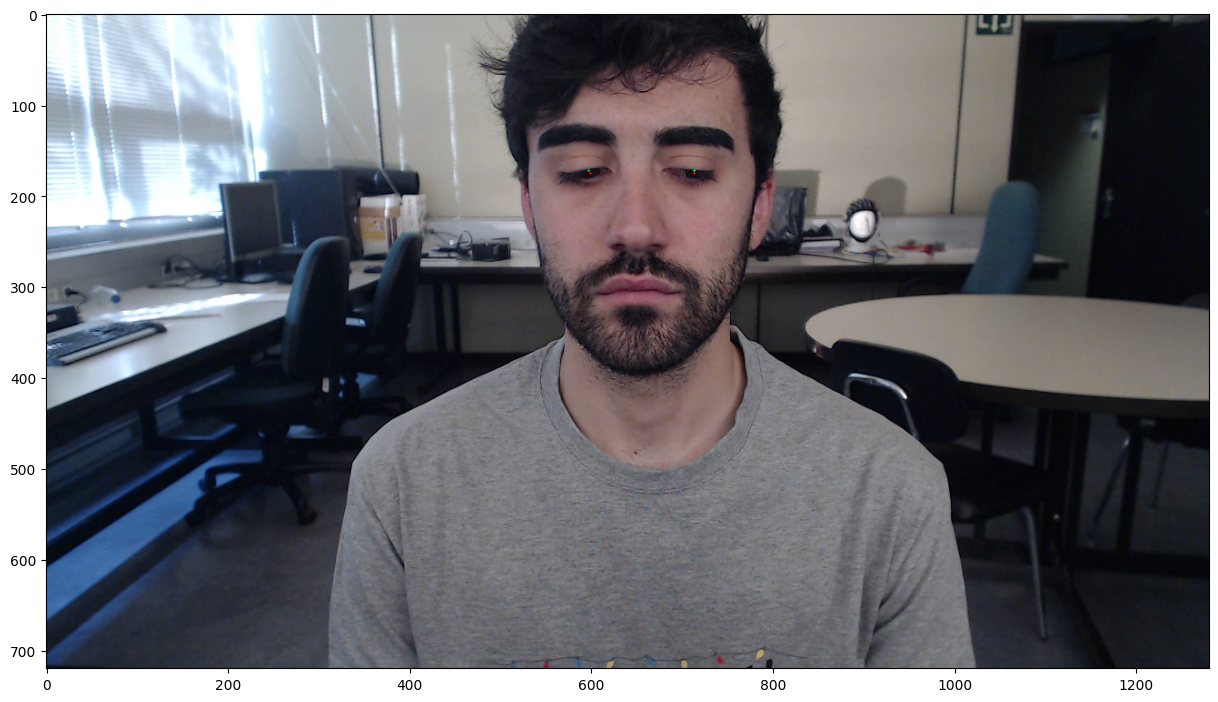

In [25]:
plt.figure(figsize=(15,15))
plt.imshow(img[:,:,::-1])
